In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/drive/My Drive/tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)

In [17]:
df = df.rename(columns={'content': 'tweet', 'sentiment': 'label'})
labels = ['neutral', 'sadness', 'happiness']
df = df.query('label in @labels')

In [18]:
df['label'] = df['label'].replace('sadness', 'negative')
df['label'] = df['label'].replace('happiness', 'positive')
data = df.dropna().reset_index(drop=True)

In [19]:
data_pos = data.query('label == "positive"')[:5000]
data_neu = data.query('label == "neutral"')[:5000]
data_neg = data.query('label == "negative"')[:5000]

data_final = pd.concat([data_pos, data_neu, data_neg])

In [20]:
# Encode labels
label_encoder = LabelEncoder()
data_final['label_enc'] = label_encoder.fit_transform(data_final['label'])

data_final.rename(columns={'label':'label_desc'},inplace=True)
data_final.rename(columns={'label_enc':'label'},inplace=True)

In [21]:
label_map = {}
for index, row in data_final[['label_desc', 'label']].drop_duplicates(keep='first').iterrows():
    label_map[row['label']] = row['label_desc']
label_map

{2: 'positive', 1: 'neutral', 0: 'negative'}

In [22]:
# Split data
X = data_final['tweet']
y = data_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_)).to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
train_inputs = [tokenizer.encode(sent, add_special_tokens=True,
               max_length=256, pad_to_max_length=True) for sent in X_train]
test_inputs = [tokenizer.encode(sent, add_special_tokens=True,
               max_length=256, pad_to_max_length=True) for sent in X_test]

# Create attention masks
train_masks = [[float(i > 0) for i in seq] for seq in train_inputs]
test_masks = [[float(i > 0) for i in seq] for seq in test_inputs]

# Convert all data into torch tensors
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(y_train.values)

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)
test_labels = torch.tensor(y_test.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
batch_size = 32

# Create DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [27]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()

    total_loss = 0
    train_accuracy = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        batch_input_ids, batch_input_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_input_mask = batch_input_mask.to(device)
        batch_labels = batch_labels.to(device)

        model.zero_grad()

        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(logits, dim=1)
        train_accuracy += (preds == batch_labels).sum().item() / len(batch_labels)

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    print(f"Training loss: {avg_train_loss:.4f}")
    print(f"Training accuracy: {avg_train_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_accuracy = 0
    for batch in tqdm(test_dataloader, desc="Validation"):
        batch_input_ids, batch_input_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_input_mask = batch_input_mask.to(device)
        batch_labels = batch_labels.to(device)

        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=batch_labels)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_accuracy += (preds == batch_labels).sum().item() / len(batch_labels)

    avg_val_accuracy = val_accuracy / len(test_dataloader)
    print(f"Validation accuracy: {avg_val_accuracy:.4f}")

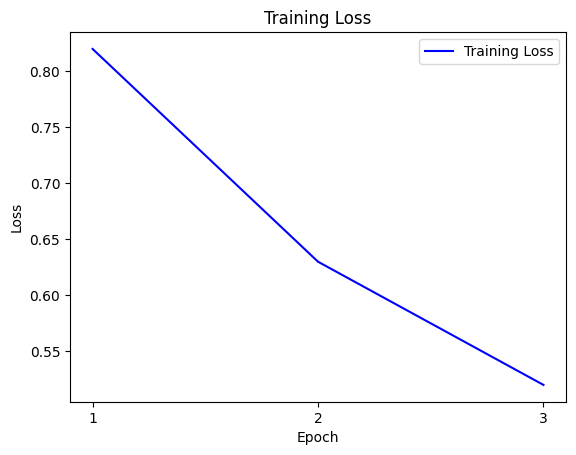

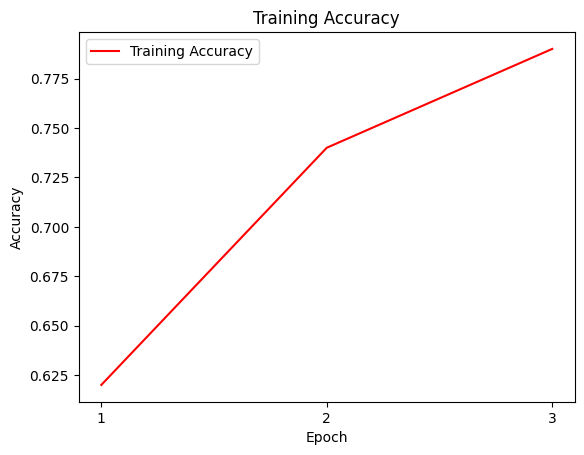

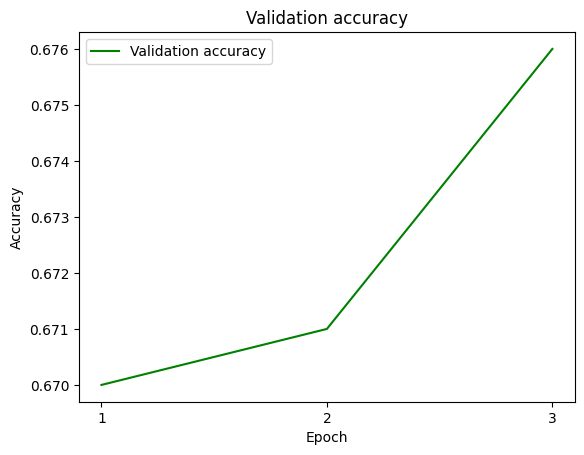

In [29]:
import matplotlib.pyplot as plt

# Loss and accuracy values recorded during training
train_losses = [0.82, 0.63, 0.52]
train_accuracies = [0.62, 0.74, 0.79]
Validation_accuracy = [0.670,0.671,0.676]

epochs = range(1, len(train_losses) + 1)

# Plotting the loss values
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

# Plotting the accuracy values
plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

#Validation accuracy
plt.plot(epochs, Validation_accuracy, 'g', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

In [ ]:
model.save_pretrained('/content/drive/My Drive/BERT/bert-emotion-classifier3Class')
tokenizer.save_pretrained('/content/drive/My Drive/BERT/bert-emotion-classifier3Class')

('/content/drive/My Drive/Colab Notebooks/YapayZekaDonemSonuUygulaması(Emotion detection from text)/BERT/bert-emotion-classifier3Class/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/YapayZekaDonemSonuUygulaması(Emotion detection from text)/BERT/bert-emotion-classifier3Class/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/YapayZekaDonemSonuUygulaması(Emotion detection from text)/BERT/bert-emotion-classifier3Class/vocab.txt',
 '/content/drive/My Drive/Colab Notebooks/YapayZekaDonemSonuUygulaması(Emotion detection from text)/BERT/bert-emotion-classifier3Class/added_tokens.json')

In [ ]:
model_path = '/content/drive/My Drive/BERT/bert-emotion-classifier3Class'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
def predict_emotion(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

In [33]:
text = "the weather is very nice today."
predicted_label = predict_emotion(text)
print(f"Metin: {text}")
print(f"Tahmin Edilen Etiket: {predicted_label}")

Metin: the weather is very nice today.
Tahmin Edilen Etiket: positive
